# Plot the number of participants

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

## Load the data
it's a .csv that contains all the annotations in this repo, with one row per annotation

In [2]:
current_folder = globals()['_dh'][0]
data_path = os.path.join(current_folder, "all_annotations.csv")
df = pd.read_csv(data_path, index_col=False)
df.pmcid = df.pmcid.astype(int)
df.head(3)

,pmcid,doi,document_utf8_text_md5_checksum,document_file,document_from_project,annotation_label_name,annotated_text,annotated_sentence,annotated_paragraph,annotation_file,annotation_project,labelbuddy_display_title
0,7563756,10.3390/brainsci10090603,57be0e414d83cf88df7d14070e3ea9dd,documents_00001.jsonl,participant_demographics,N participants,Twenty-nine,Subjects and Experimental Design \n \nTwenty...,Twenty-nine healthy volunteers participated in...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...
1,5030332,10.1016/j.nicl.2016.07.006,9eef6f93a376b2d0833d2fe6dc4fb6a3,documents_00001.jsonl,participant_demographics,N participants,21,\n\n## Method \n \n### Participants \n \nTh...,The sample consisted of 21 participants who me...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...
2,6678781,10.3390/jcm8070947,bfd271e0496c07e5675e92cb777729c0,documents_00001.jsonl,participant_demographics,N participants,Seventy-nine,Seventy-nine male pedophilic CSOs were examin...,High prevalence of child sexual offending stan...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...


## View labels used in each project

In [3]:
for project, group in df.groupby("document_from_project"):
    print('Project: ', project.upper())
    labels = list(set(group['annotation_label_name']))
    labels.sort()
    print('Labels: ')
    for label in labels:
        print("\t", label)
    print('-----------------------')
    

Project:  AUTISM_MRI
Labels: 
	 Age_Max
	 Age_Min
	 AnalysisTool
	 Diagnosis
	 FieldStrength
	 MRI_Modality
	 N_Controls
	 N_Controls_Female
	 N_Controls_Male
	 N_Patients
	 N_Patients_Female
	 N_Patients_Male
	 N_Total
	 Scanner
-----------------------
Project:  CLUSTER_INFERENCE
Labels: 
	 annotation_in_progress
	 bad_methods_example
	 cluster_thresh_in_mm
	 cluster_thresh_in_voxels
	 cluster_thresh_used
	 difficult_annotation_example
	 discard_this_paper
	 funny_topic
	 info_removed_in_text_extract
	 n_participants
	 n_participants_excluded
	 n_participants_in_subgroup
	 n_participants_total
	 nonparametric_cluster_thresh
	 smoothing_snippet
	 voxel_size_snippet
-----------------------
Project:  PARTICIPANT_DEMOGRAPHICS
Labels: 
	 N included
	 N participants
-----------------------


## Choose which labels to use
by inspecting the lists above

In [4]:
select_labels = [
    "N included",
    "n_participants",
    "n_participants_total",
    "N_Total"
]

## Select the subset of the dataframe that contains one of our select labels

In [5]:
df_subset = df[df["annotation_label_name"].isin(select_labels)]
df_subset.head(3)

,pmcid,doi,document_utf8_text_md5_checksum,document_file,document_from_project,annotation_label_name,annotated_text,annotated_sentence,annotated_paragraph,annotation_file,annotation_project,labelbuddy_display_title
3,6678781,10.3390/jcm8070947,bfd271e0496c07e5675e92cb777729c0,documents_00001.jsonl,participant_demographics,N included,Sixty-one,Sixty-one participants (38 convicted) underwe...,High prevalence of child sexual offending stan...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...
9,8154462,10.1097/MD.0000000000025823,df8efced4b837b724fc973e8161c67e7,documents_00001.jsonl,participant_demographics,N included,20,Using fMRI in 20 participants (11 right MCA i...,Sexual dysfunction is a common problem after c...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...
11,5324609,10.1002/hipo.22688,16ef9d7ab42b76b944ac37702a03bbb3,documents_00001.jsonl,participant_demographics,N included,15,"As such, analyses reported here used data fro...",Twenty‐three right‐handed students were recrui...,Jerome_Dockes.json,participant_demographics,pmcid: <a href=https://www.ncbi.nlm.nih.gov/pm...


## [make sure there's only one row for each pmid]

## Convert the annotated text to integers
this is not the best way, I think. 

In [6]:
from participants_demographics import _reading


class TextToNumber:
    def __init__(self):
        self.parser = _reading._get_parser(
            start="number", ambiguity="resolve", grammar="numbers_grammar"
        )
        self.transformer = _reading.ParticipantsTransformer(0)

    def __call__(self, text):
        try:
            parse_tree = self.parser.parse(text)
            return self.transformer.transform(parse_tree).value
        except Exception:
            return None
text_to_num = TextToNumber()

for i, row in df_subset.iterrows():
    n_str = row['annotated_text']
    n_int = text_to_num(n_str)
    df_subset.loc[i, "n_ptp_int"] = n_int

/tmp/ipykernel_41947/1627780195.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[i, "n_ptp_int"] = n_int


Text(0.5, 0, 'Number of participants')

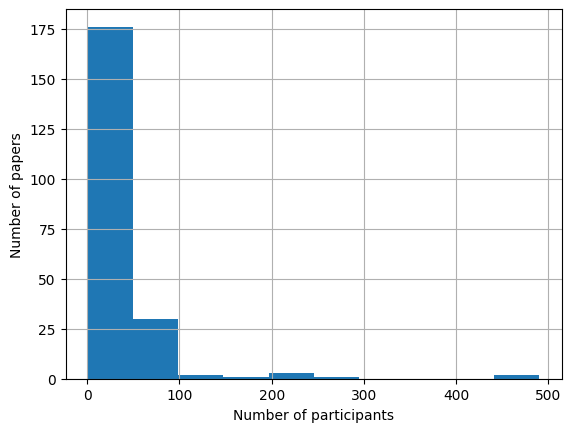

In [7]:
fig, ax = plt.subplots()
df_subset['n_ptp_int'].hist()
ax.set_ylabel('Number of papers')
ax.set_xlabel('Number of participants')